# Introduction

Importo il necessario


In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import operator
import random
import re
import csv
import numpy as np
import pandas as pd
import seaborn as sn
import ghlinguist as ghl
import os.path
import _pickle as cPickle
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.feature_extraction as fe
import sklearn.model_selection as ms
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
plt.style.use('seaborn')

# Document retrieval

Vado a recuperare i file che mi servono per la fase di training/testing. Il ciclo `for` serve per cerca nella repo clonata tutti i file la cui estensione appartiene alla lista `accepted`. Le estensioni presenti nell'array `accepted` sono le classi del classificatore. Quando un file che soddisfa il vincolo dell'estensione viene trovato, si controlla tramite il dict `file_num` che per quella estensione non sia già stato raggiunto il `max_num_of_files`. Infine, se tutti i controlli vengono superati, il file viene aggiunto all'array `file_list` e la sua estensione a `file_ext`. In `file_ext[i]` è presente l'estensione del file `file_list[i]`. La fine della cella serve per disegnare il Dataframe riepilogativo e un grafico a torta (attualmente inutile perchè viene usato un numero fisso di file `max_num_of_files`).



Num    120
dtype: int64


,Num
C,5
Common Lisp,5
Go,5
TypeScript,5
Ruby,5
Prolog,5
CMake,5
Shell,5
OCaml,5
Makefile,5


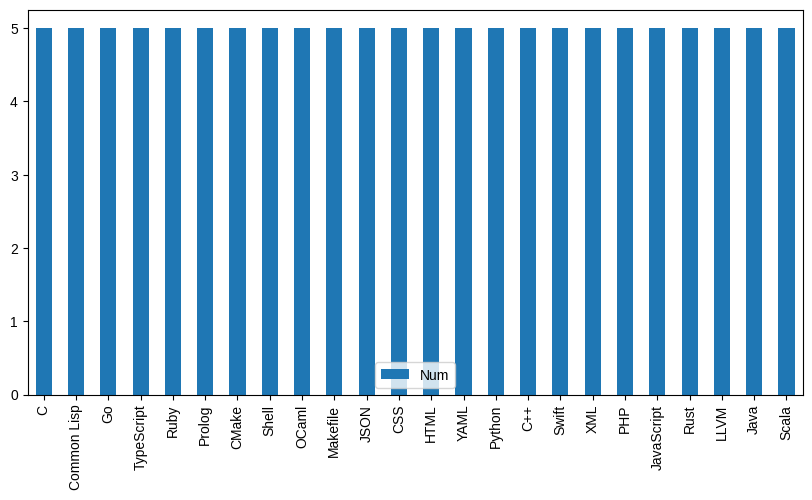

In [22]:
plt.style.use('default')

def check_open_utf8(f):
    try:
        open(f, 'r').read()
        return True
    except:
        return False

file_num = {}
file_list = []
file_ext = []
accepted = ["Java", "C++", "LLVM", "PHP", "C", "Rust", "Swift", "Common Lisp", "JavaScript","YAML", \
             "Python", "HTML", "XML", "JSON", "Makefile", "OCaml", "Shell", "CMake", "Ruby", "TypeScript", \
            "Scala", "Go", "CSS", "Prolog"]
max_num_of_files = 5

with open('source-code-set/listing.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    for row in csv_reader:
        if len(row) > 1:
            if row[0] and row[1]:
                if os.path.isfile(row[0]):
                    if row[1] in accepted:
                        add = False
                        if check_open_utf8(row[0]):
                            if row[1] in file_num:
                                if file_num[row[1]] < max_num_of_files:
                                    add = True
                                    file_num[row[1]] += 1
                            else:
                                add = True
                                file_num[row[1]] = 1
                            if add:
                                file_list.append(row[0])
                                file_ext.append(row[1])
    
# Mostro in output le informazioni sui file acquisiti
data = pd.DataFrame.from_dict(file_num, orient='index', columns=["Num"])
data = data.sort_values(by=["Num"], ascending=False)
# Disegno un grafico che le mostri
pie_chart = data.plot.bar(y='Num', figsize=(10,5))
pie_chart.get_figure()
plt.style.use('seaborn')
print(data.sum(axis = 0, skipna = True))
data

# NLP

La funzione `preprocess` prende in input la lista contenente il nome dei file accettati nella sezione precedente, legge il contenuto dei documenti e restituisce una serie (di *Pandas*) con il contenuto dei file opportunamente modificato. Il primo e il secondo replace rimuovono tutte le stringhe del tipo `xxxx`, `aaaaa`, `b`, `c`. I successivi replace vanno a sostituire con delle keyword le porzioni di stringa contenenti commenti. Infatti, non mi interessa sapere il contenuto di un commento, è molto più interessante sapere il tipo di commento (e.g. `//.*?\n` diventa `ccommentstyle` nei linguaggi C-like o `#.*?\n` diventa `pycommentstyle` in quelli funzioniali/Python-like). Se si volessero inserire anche linguaggi come Prolog bisognerebbe aggiungere un replace per i commenti in stile `%.*?\n`.




La funzione `tokenizer`, invece, tramite `re.findall()` cerca, nella stringa in input, tutte le occorrenze che coincidono con la regex `token_pattern`. Infine, `tokenizer` cerca tra i token restituiti da `re.findall()`quelli che sono numerici e li rimpiazza con un token predefinito `XXXtokenNumberXXX`. L'output della funzione è una lista di tokens.

A questo punto vengono divisi training e test set, oltre a venir dichiarati `transformer` e `tfidf_vectorizer`. Il `TfidfVectorizer` ha come tokenizer la funzione `tokenizer` (di cui si è discusso prima), un numero di feature massimo di 3000 e gli ngram spaziano da 1 a 3. Tramite il Dataframe si possono visualizzare le 3000 feature, riportate tramite `PCA` anche nel grafico.

,\t,\t \t,\t $,\t <,\t [,\t case,\t ccommentstyle,\t def,\t doublequotedstring,\t dune,...,} in,} let,} nav,} pycommentstyle,} return,} union,} var,} {,} },~
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.013384,0.0,0.070749,0.0,0.024904,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
86,0.306579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.488114,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
87,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.019126,0.0
88,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.072911,0.000000,0.0,0.000000,0.0,0.000000,0.0


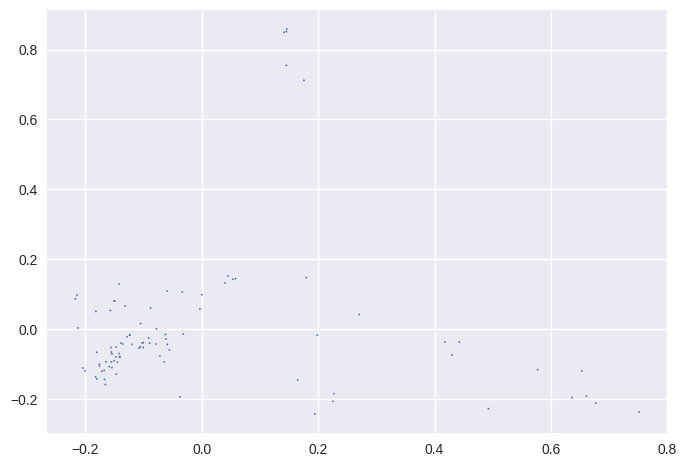

In [23]:
def preprocess(x):
    ls_file = list(map(lambda v: open(v, 'r').read(), x))
    return pd.Series(ls_file).replace(r'\b([A-Za-z])\1+\b', '', regex=True) \
        .replace(r'\b[A-Za-z]\b', '', regex=True) \
        .replace(r'\/\*(\*(?!\/)|[^*])*\*\/', ' ccommentstyle ', regex=True) \
        .replace(r'//.*?\n', ' ccommentstyle ', regex=True) \
        .replace(r'#.*?\n', ' pycommentstyle ', regex=True) \
        .replace(r'%.*?\n', ' prologcommentstyle ', regex=True) \
        .replace(r'".*?"', ' doublequotedstring ', regex=True) \
        .replace(r"'.*?'", ' singlequotedstring ', regex=True) \
        .replace(r"'.'", ' singlecharacter ') \
        .replace(r'\(\*(\*(?!\))|[^*])*\*\)', ' mlcommentstyle ', regex=True)\
        .replace(r'<!--(.*?)-->', ' htmlcommentstyle ', regex=True)\
        .replace(r'<!--(.*?)-->', ' htmlcommentstyle ', regex=True)


def check_num(x):
    if x.isnumeric():
        return "XXXtokenNumberXXX"
    else:
        return x


def tokenizer(txt):
    token_pattern = r"""([0-9]+|[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[\t\(\),;\{\}\[\]"'`])"""
    tokens = re.findall(token_pattern, txt)
    tokens = list(map(check_num, tokens))
    return tokens

X_train, X_test, y_train, y_test = ms.train_test_split(file_list, file_ext, shuffle=True, test_size=0.25, random_state=0)
transformer = FunctionTransformer(preprocess)
tfidf_vectorizer = fe.text.TfidfVectorizer(ngram_range=range(1, 3), tokenizer=tokenizer, max_features=3000)
# Visualization
X = tfidf_vectorizer.fit_transform(transformer.fit_transform(X_train))


lb = LabelBinarizer()
lb.fit(accepted)
        
pca = PCA(n_components=2)
two_dim = pca.fit_transform(X.todense())
s = [1 for n in range(len(two_dim[:, 0]))]
plt.scatter(two_dim[:, 0], two_dim[:, 1], s=s)
plt
pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names())

# ML Parameters

Modelli, e relativi parametri, che vengono testati 

In [24]:
result = []

y_train_enc = lb.transform(y_train)

input_dim = X.toarray().shape[1]
output_dim = len(y_train_enc[0])
dim = int(2/3 * input_dim + output_dim)

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(dim, input_dim=input_dim, activation='relu'))
    model.add(Dense(dim, activation='relu'))
    model.add(Dense(output_dim, activation='softmax'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

ann_model = KerasClassifier(build_fn=baseline_model)
parameters = [ 
    {
        'clf':[ 
            Pipeline(
                [
                    ('transformer', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)), 
                    ('clf', ann_model)
                ]
            )
        ],
        'name': 'ANN',
        'clf__clf__epochs': [10,50,100],
        'clf__clf__batch_size': [32,64,128,256],
        'clf__clf__verbose':[2]
    },
    {
        'clf': [RandomForestClassifier(n_jobs=-1)],
        'name': 'RandomForestClassifier',
        "clf__n_estimators": [300,500, 1000],
        "clf__criterion": ["gini", "entropy"],
        "clf__min_samples_split": [3],
        "clf__max_features": ["sqrt", "log2"]
    },
    {
        'clf': [SVC()],
        'name': 'SVC',
        'clf__C': [100,500, 1000, 10e5],
        'clf__kernel': ['rbf'],
        'clf__class_weight': ['balanced'],
        'clf__probability': [True]
    }
]

# Fitting

Tramite `CV`, viene fatto il training dei vari modelli e viene stampato un valore di Accuracy. I risultati vengono memorizzati in **result** per una comparazione successiva.

Di seguito una matrice di confusione per visualizzare i risultati. Questa matrice fa riferimento al miglior modello (Random Forest con parametri precedenti). I valori sono normalizzati. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java e JavaScript.

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 


/home/federico/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV]  clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=100, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=500, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True, total=   0.1s
[CV] clf__C=1000, clf__class_weight=balanced, clf__kernel=rbf, clf__probability=True 
[CV]  clf__C=1000, clf__class_weight=balanced, clf__kernel=rbf, clf__proba

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    1.2s finished


 - SVC Accuracy: 0.7


<module 'matplotlib.pyplot' from '/home/federico/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

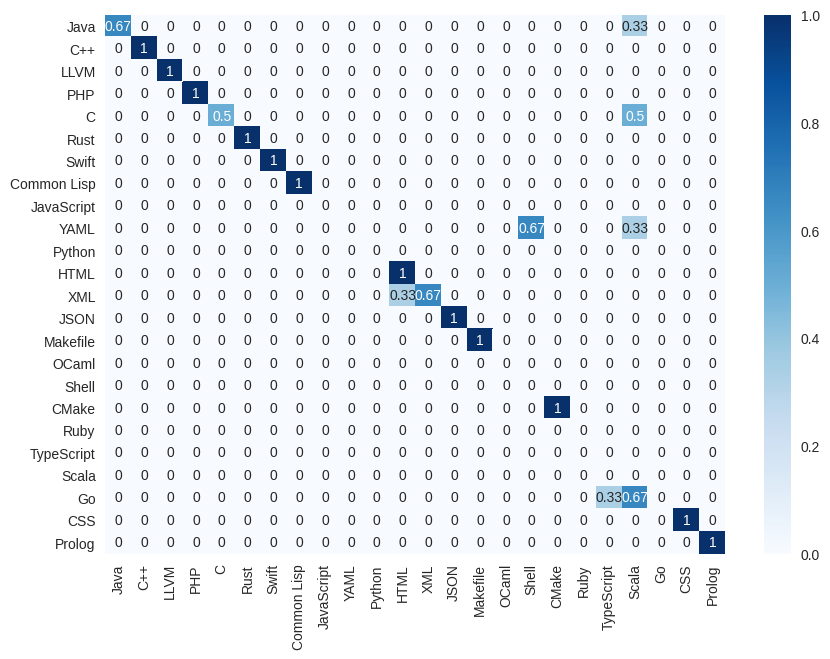

In [25]:
clf = parameters[2]['clf'][0]
name = parameters[2]['name']
parameters[2].pop('clf')
parameters[2].pop('name')

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[2], cv=3, verbose=2)

grid.fit(X_train, y_train)
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, y_test)}')

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

SVC = result[0]
y_pred = SVC["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Questa matrice fa riferimento al secondo miglior modello (SVM con kernel=RBF e C=50). I valori sono normalizzati. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java, JavaScript e C++.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=2 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/10
2/2 - 0s - loss: 3.1472 - accuracy: 0.2333
Epoch 2/10
2/2 - 0s - loss: 2.8128 - accuracy: 0.9167
Epoch 3/10
2/2 - 0s - loss: 2.3275 - accuracy: 0.9167
Epoch 4/10
2/2 - 0s - loss: 1.6768 - accuracy: 0.9167
Epoch 5/10
2/2 - 0s - loss: 1.0400 - accuracy: 0.9333
Epoch 6/10
2/2 - 0s - loss: 0.5526 - accuracy: 0.9500
Epoch 7/10
2/2 - 0s - loss: 0.2775 - accuracy: 0.9667
Epoch 8/10
2/2 - 0s - loss: 0.1142 - accuracy: 0.9833
Epoch 9/10
2/2 - 0s - loss: 0.0496 - accuracy: 1.0000
Epoch 10/10
2/2 - 0s - loss: 0.0235 - accuracy: 1.0000
1/1 - 0s - loss: 2.2956 - accuracy: 0.7667
[CV]  clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=2, total=   2.3s
[CV] clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=2 
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


2/2 - 0s - loss: 3.1548 - accuracy: 0.2000
Epoch 2/10
2/2 - 0s - loss: 2.8421 - accuracy: 0.7833
Epoch 3/10
2/2 - 0s - loss: 2.3952 - accuracy: 0.9167
Epoch 4/10
2/2 - 0s - loss: 1.7789 - accuracy: 0.9500
Epoch 5/10
2/2 - 0s - loss: 1.1529 - accuracy: 0.9500
Epoch 6/10
2/2 - 0s - loss: 0.6606 - accuracy: 0.9833
Epoch 7/10
2/2 - 0s - loss: 0.3196 - accuracy: 0.9833
Epoch 8/10
2/2 - 0s - loss: 0.1490 - accuracy: 0.9833
Epoch 9/10
2/2 - 0s - loss: 0.0632 - accuracy: 0.9833
Epoch 10/10
2/2 - 0s - loss: 0.0366 - accuracy: 0.9833
1/1 - 0s - loss: 1.5233 - accuracy: 0.7333
[CV]  clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=2, total=   1.1s
[CV] clf__clf__batch_size=32, clf__clf__epochs=10, clf__clf__verbose=2 
Epoch 1/10
2/2 - 0s - loss: 3.1612 - accuracy: 0.1167
Epoch 2/10
2/2 - 0s - loss: 2.8586 - accuracy: 0.8500
Epoch 3/10
2/2 - 0s - loss: 2.4177 - accuracy: 0.9500
Epoch 4/10
2/2 - 0s - loss: 1.8141 - accuracy: 0.9667
Epoch 5/10
2/2 - 0s - loss: 1.1493 - accuracy: 0.966

Epoch 27/50
2/2 - 0s - loss: 1.0252e-04 - accuracy: 1.0000
Epoch 28/50
2/2 - 0s - loss: 9.2724e-05 - accuracy: 1.0000
Epoch 29/50
2/2 - 0s - loss: 8.1137e-05 - accuracy: 1.0000
Epoch 30/50
2/2 - 0s - loss: 6.9948e-05 - accuracy: 1.0000
Epoch 31/50
2/2 - 0s - loss: 6.3749e-05 - accuracy: 1.0000
Epoch 32/50
2/2 - 0s - loss: 5.9913e-05 - accuracy: 1.0000
Epoch 33/50
2/2 - 0s - loss: 5.5527e-05 - accuracy: 1.0000
Epoch 34/50
2/2 - 0s - loss: 5.1155e-05 - accuracy: 1.0000
Epoch 35/50
2/2 - 0s - loss: 4.8373e-05 - accuracy: 1.0000
Epoch 36/50
2/2 - 0s - loss: 4.6578e-05 - accuracy: 1.0000
Epoch 37/50
2/2 - 0s - loss: 4.4093e-05 - accuracy: 1.0000
Epoch 38/50
2/2 - 0s - loss: 4.2465e-05 - accuracy: 1.0000
Epoch 39/50
2/2 - 0s - loss: 4.1327e-05 - accuracy: 1.0000
Epoch 40/50
2/2 - 0s - loss: 3.9833e-05 - accuracy: 1.0000
Epoch 41/50
2/2 - 0s - loss: 3.8939e-05 - accuracy: 1.0000
Epoch 42/50
2/2 - 0s - loss: 3.7923e-05 - accuracy: 1.0000
Epoch 43/50
2/2 - 0s - loss: 3.6868e-05 - accuracy: 1.00

Epoch 36/100
2/2 - 0s - loss: 6.1353e-05 - accuracy: 1.0000
Epoch 37/100
2/2 - 0s - loss: 5.9292e-05 - accuracy: 1.0000
Epoch 38/100
2/2 - 0s - loss: 5.7089e-05 - accuracy: 1.0000
Epoch 39/100
2/2 - 0s - loss: 5.5585e-05 - accuracy: 1.0000
Epoch 40/100
2/2 - 0s - loss: 5.3754e-05 - accuracy: 1.0000
Epoch 41/100
2/2 - 0s - loss: 5.2495e-05 - accuracy: 1.0000
Epoch 42/100
2/2 - 0s - loss: 5.1164e-05 - accuracy: 1.0000
Epoch 43/100
2/2 - 0s - loss: 5.0045e-05 - accuracy: 1.0000
Epoch 44/100
2/2 - 0s - loss: 4.8770e-05 - accuracy: 1.0000
Epoch 45/100
2/2 - 0s - loss: 4.7944e-05 - accuracy: 1.0000
Epoch 46/100
2/2 - 0s - loss: 4.6963e-05 - accuracy: 1.0000
Epoch 47/100
2/2 - 0s - loss: 4.6025e-05 - accuracy: 1.0000
Epoch 48/100
2/2 - 0s - loss: 4.5254e-05 - accuracy: 1.0000
Epoch 49/100
2/2 - 0s - loss: 4.4345e-05 - accuracy: 1.0000
Epoch 50/100
2/2 - 0s - loss: 4.3669e-05 - accuracy: 1.0000
Epoch 51/100
2/2 - 0s - loss: 4.2948e-05 - accuracy: 1.0000
Epoch 52/100
2/2 - 0s - loss: 4.2293e-05

2/2 - 0s - loss: 3.3415e-05 - accuracy: 1.0000
Epoch 59/100
2/2 - 0s - loss: 3.3045e-05 - accuracy: 1.0000
Epoch 60/100
2/2 - 0s - loss: 3.2571e-05 - accuracy: 1.0000
Epoch 61/100
2/2 - 0s - loss: 3.2195e-05 - accuracy: 1.0000
Epoch 62/100
2/2 - 0s - loss: 3.1740e-05 - accuracy: 1.0000
Epoch 63/100
2/2 - 0s - loss: 3.1410e-05 - accuracy: 1.0000
Epoch 64/100
2/2 - 0s - loss: 3.1025e-05 - accuracy: 1.0000
Epoch 65/100
2/2 - 0s - loss: 3.0654e-05 - accuracy: 1.0000
Epoch 66/100
2/2 - 0s - loss: 3.0248e-05 - accuracy: 1.0000
Epoch 67/100
2/2 - 0s - loss: 2.9889e-05 - accuracy: 1.0000
Epoch 68/100
2/2 - 0s - loss: 2.9603e-05 - accuracy: 1.0000
Epoch 69/100
2/2 - 0s - loss: 2.9213e-05 - accuracy: 1.0000
Epoch 70/100
2/2 - 0s - loss: 2.8941e-05 - accuracy: 1.0000
Epoch 71/100
2/2 - 0s - loss: 2.8625e-05 - accuracy: 1.0000
Epoch 72/100
2/2 - 0s - loss: 2.8252e-05 - accuracy: 1.0000
Epoch 73/100
2/2 - 0s - loss: 2.7938e-05 - accuracy: 1.0000
Epoch 74/100
2/2 - 0s - loss: 2.7700e-05 - accuracy: 

2/2 - 0s - loss: 2.0276e-05 - accuracy: 1.0000
Epoch 81/100
2/2 - 0s - loss: 2.0047e-05 - accuracy: 1.0000
Epoch 82/100
2/2 - 0s - loss: 1.9855e-05 - accuracy: 1.0000
Epoch 83/100
2/2 - 0s - loss: 1.9630e-05 - accuracy: 1.0000
Epoch 84/100
2/2 - 0s - loss: 1.9479e-05 - accuracy: 1.0000
Epoch 85/100
2/2 - 0s - loss: 1.9279e-05 - accuracy: 1.0000
Epoch 86/100
2/2 - 0s - loss: 1.9090e-05 - accuracy: 1.0000
Epoch 87/100
2/2 - 0s - loss: 1.8887e-05 - accuracy: 1.0000
Epoch 88/100
2/2 - 0s - loss: 1.8724e-05 - accuracy: 1.0000
Epoch 89/100
2/2 - 0s - loss: 1.8547e-05 - accuracy: 1.0000
Epoch 90/100
2/2 - 0s - loss: 1.8351e-05 - accuracy: 1.0000
Epoch 91/100
2/2 - 0s - loss: 1.8202e-05 - accuracy: 1.0000
Epoch 92/100
2/2 - 0s - loss: 1.8005e-05 - accuracy: 1.0000
Epoch 93/100
2/2 - 0s - loss: 1.7828e-05 - accuracy: 1.0000
Epoch 94/100
2/2 - 0s - loss: 1.7693e-05 - accuracy: 1.0000
Epoch 95/100
2/2 - 0s - loss: 1.7544e-05 - accuracy: 1.0000
Epoch 96/100
2/2 - 0s - loss: 1.7367e-05 - accuracy: 

Epoch 30/50
1/1 - 0s - loss: 3.5981e-04 - accuracy: 1.0000
Epoch 31/50
1/1 - 0s - loss: 2.8208e-04 - accuracy: 1.0000
Epoch 32/50
1/1 - 0s - loss: 2.2513e-04 - accuracy: 1.0000
Epoch 33/50
1/1 - 0s - loss: 1.8308e-04 - accuracy: 1.0000
Epoch 34/50
1/1 - 0s - loss: 1.5169e-04 - accuracy: 1.0000
Epoch 35/50
1/1 - 0s - loss: 1.2788e-04 - accuracy: 1.0000
Epoch 36/50
1/1 - 0s - loss: 1.0951e-04 - accuracy: 1.0000
Epoch 37/50
1/1 - 0s - loss: 9.5106e-05 - accuracy: 1.0000
Epoch 38/50
1/1 - 0s - loss: 8.3580e-05 - accuracy: 1.0000
Epoch 39/50
1/1 - 0s - loss: 7.4257e-05 - accuracy: 1.0000
Epoch 40/50
1/1 - 0s - loss: 6.6610e-05 - accuracy: 1.0000
Epoch 41/50
1/1 - 0s - loss: 6.0253e-05 - accuracy: 1.0000
Epoch 42/50
1/1 - 0s - loss: 5.4919e-05 - accuracy: 1.0000
Epoch 43/50
1/1 - 0s - loss: 5.0390e-05 - accuracy: 1.0000
Epoch 44/50
1/1 - 0s - loss: 4.6489e-05 - accuracy: 1.0000
Epoch 45/50
1/1 - 0s - loss: 4.3147e-05 - accuracy: 1.0000
Epoch 46/50
1/1 - 0s - loss: 4.0225e-05 - accuracy: 1.00

Epoch 41/50
1/1 - 0s - loss: 1.6617e-05 - accuracy: 1.0000
Epoch 42/50
1/1 - 0s - loss: 1.5649e-05 - accuracy: 1.0000
Epoch 43/50
1/1 - 0s - loss: 1.4817e-05 - accuracy: 1.0000
Epoch 44/50
1/1 - 0s - loss: 1.4062e-05 - accuracy: 1.0000
Epoch 45/50
1/1 - 0s - loss: 1.3400e-05 - accuracy: 1.0000
Epoch 46/50
1/1 - 0s - loss: 1.2808e-05 - accuracy: 1.0000
Epoch 47/50
1/1 - 0s - loss: 1.2282e-05 - accuracy: 1.0000
Epoch 48/50
1/1 - 0s - loss: 1.1815e-05 - accuracy: 1.0000
Epoch 49/50
1/1 - 0s - loss: 1.1382e-05 - accuracy: 1.0000
Epoch 50/50
1/1 - 0s - loss: 1.0997e-05 - accuracy: 1.0000
1/1 - 0s - loss: 2.5006 - accuracy: 0.7000
[CV]  clf__clf__batch_size=64, clf__clf__epochs=50, clf__clf__verbose=2, total=   2.1s
[CV] clf__clf__batch_size=64, clf__clf__epochs=100, clf__clf__verbose=2 
Epoch 1/100
1/1 - 0s - loss: 3.1789 - accuracy: 0.0167
Epoch 2/100
1/1 - 0s - loss: 2.9970 - accuracy: 0.9000
Epoch 3/100
1/1 - 0s - loss: 2.7873 - accuracy: 0.9333
Epoch 4/100
1/1 - 0s - loss: 2.5038 - accu

Epoch 1/100
1/1 - 0s - loss: 3.1758 - accuracy: 0.0167
Epoch 2/100
1/1 - 0s - loss: 3.0029 - accuracy: 0.9667
Epoch 3/100
1/1 - 0s - loss: 2.8042 - accuracy: 0.9833
Epoch 4/100
1/1 - 0s - loss: 2.5368 - accuracy: 0.9833
Epoch 5/100
1/1 - 0s - loss: 2.1944 - accuracy: 0.9500
Epoch 6/100
1/1 - 0s - loss: 1.7897 - accuracy: 0.9500
Epoch 7/100
1/1 - 0s - loss: 1.3635 - accuracy: 0.9500
Epoch 8/100
1/1 - 0s - loss: 0.9746 - accuracy: 0.9667
Epoch 9/100
1/1 - 0s - loss: 0.6583 - accuracy: 0.9833
Epoch 10/100
1/1 - 0s - loss: 0.4189 - accuracy: 0.9833
Epoch 11/100
1/1 - 0s - loss: 0.2505 - accuracy: 0.9833
Epoch 12/100
1/1 - 0s - loss: 0.1440 - accuracy: 0.9833
Epoch 13/100
1/1 - 0s - loss: 0.0842 - accuracy: 0.9833
Epoch 14/100
1/1 - 0s - loss: 0.0517 - accuracy: 0.9833
Epoch 15/100
1/1 - 0s - loss: 0.0316 - accuracy: 0.9833
Epoch 16/100
1/1 - 0s - loss: 0.0178 - accuracy: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.0098 - accuracy: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.0068 - accuracy: 1.0000
E

1/1 - 0s - loss: 1.3259e-04 - accuracy: 1.0000
Epoch 26/100
1/1 - 0s - loss: 1.0191e-04 - accuracy: 1.0000
Epoch 27/100
1/1 - 0s - loss: 7.9769e-05 - accuracy: 1.0000
Epoch 28/100
1/1 - 0s - loss: 6.3595e-05 - accuracy: 1.0000
Epoch 29/100
1/1 - 0s - loss: 5.1558e-05 - accuracy: 1.0000
Epoch 30/100
1/1 - 0s - loss: 4.2485e-05 - accuracy: 1.0000
Epoch 31/100
1/1 - 0s - loss: 3.5540e-05 - accuracy: 1.0000
Epoch 32/100
1/1 - 0s - loss: 3.0150e-05 - accuracy: 1.0000
Epoch 33/100
1/1 - 0s - loss: 2.5906e-05 - accuracy: 1.0000
Epoch 34/100
1/1 - 0s - loss: 2.2560e-05 - accuracy: 1.0000
Epoch 35/100
1/1 - 0s - loss: 1.9871e-05 - accuracy: 1.0000
Epoch 36/100
1/1 - 0s - loss: 1.7684e-05 - accuracy: 1.0000
Epoch 37/100
1/1 - 0s - loss: 1.5896e-05 - accuracy: 1.0000
Epoch 38/100
1/1 - 0s - loss: 1.4425e-05 - accuracy: 1.0000
Epoch 39/100
1/1 - 0s - loss: 1.3193e-05 - accuracy: 1.0000
Epoch 40/100
1/1 - 0s - loss: 1.2160e-05 - accuracy: 1.0000
Epoch 41/100
1/1 - 0s - loss: 1.1290e-05 - accuracy: 

1/1 - 0s - loss: 1.7807 - accuracy: 0.7000
[CV]  clf__clf__batch_size=128, clf__clf__epochs=10, clf__clf__verbose=2, total=   0.7s
[CV] clf__clf__batch_size=128, clf__clf__epochs=10, clf__clf__verbose=2 
Epoch 1/10
1/1 - 0s - loss: 3.1794 - accuracy: 0.0500
Epoch 2/10
1/1 - 0s - loss: 3.0047 - accuracy: 0.9833
Epoch 3/10
1/1 - 0s - loss: 2.8066 - accuracy: 0.9833
Epoch 4/10
1/1 - 0s - loss: 2.5417 - accuracy: 0.9833
Epoch 5/10
1/1 - 0s - loss: 2.2016 - accuracy: 0.9833
Epoch 6/10
1/1 - 0s - loss: 1.7954 - accuracy: 0.9833
Epoch 7/10
1/1 - 0s - loss: 1.3573 - accuracy: 0.9833
Epoch 8/10
1/1 - 0s - loss: 0.9425 - accuracy: 1.0000
Epoch 9/10
1/1 - 0s - loss: 0.6005 - accuracy: 1.0000
Epoch 10/10
1/1 - 0s - loss: 0.3520 - accuracy: 1.0000
1/1 - 0s - loss: 1.6025 - accuracy: 0.7667
[CV]  clf__clf__batch_size=128, clf__clf__epochs=10, clf__clf__verbose=2, total=   0.9s
[CV] clf__clf__batch_size=128, clf__clf__epochs=50, clf__clf__verbose=2 
Epoch 1/50
1/1 - 0s - loss: 3.1837 - accuracy: 0.03

1/1 - 0s - loss: 3.7865e-05 - accuracy: 1.0000
Epoch 50/50
1/1 - 0s - loss: 3.4808e-05 - accuracy: 1.0000
1/1 - 0s - loss: 3.2766 - accuracy: 0.7000
[CV]  clf__clf__batch_size=128, clf__clf__epochs=50, clf__clf__verbose=2, total=   2.1s
[CV] clf__clf__batch_size=128, clf__clf__epochs=50, clf__clf__verbose=2 
Epoch 1/50
1/1 - 0s - loss: 3.1750 - accuracy: 0.0500
Epoch 2/50
1/1 - 0s - loss: 3.0006 - accuracy: 0.9667
Epoch 3/50
1/1 - 0s - loss: 2.7986 - accuracy: 0.9833
Epoch 4/50
1/1 - 0s - loss: 2.5278 - accuracy: 0.9833
Epoch 5/50
1/1 - 0s - loss: 2.1818 - accuracy: 0.9833
Epoch 6/50
1/1 - 0s - loss: 1.7726 - accuracy: 0.9833
Epoch 7/50
1/1 - 0s - loss: 1.3360 - accuracy: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.9243 - accuracy: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.5870 - accuracy: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.3430 - accuracy: 1.0000
Epoch 11/50
1/1 - 0s - loss: 0.1848 - accuracy: 1.0000
Epoch 12/50
1/1 - 0s - loss: 0.0932 - accuracy: 1.0000
Epoch 13/50
1/1 - 0s - loss: 0.0446 - a

Epoch 59/100
1/1 - 0s - loss: 2.3749e-05 - accuracy: 1.0000
Epoch 60/100
1/1 - 0s - loss: 2.2867e-05 - accuracy: 1.0000
Epoch 61/100
1/1 - 0s - loss: 2.2054e-05 - accuracy: 1.0000
Epoch 62/100
1/1 - 0s - loss: 2.1319e-05 - accuracy: 1.0000
Epoch 63/100
1/1 - 0s - loss: 2.0636e-05 - accuracy: 1.0000
Epoch 64/100
1/1 - 0s - loss: 2.0018e-05 - accuracy: 1.0000
Epoch 65/100
1/1 - 0s - loss: 1.9434e-05 - accuracy: 1.0000
Epoch 66/100
1/1 - 0s - loss: 1.8908e-05 - accuracy: 1.0000
Epoch 67/100
1/1 - 0s - loss: 1.8413e-05 - accuracy: 1.0000
Epoch 68/100
1/1 - 0s - loss: 1.7946e-05 - accuracy: 1.0000
Epoch 69/100
1/1 - 0s - loss: 1.7523e-05 - accuracy: 1.0000
Epoch 70/100
1/1 - 0s - loss: 1.7114e-05 - accuracy: 1.0000
Epoch 71/100
1/1 - 0s - loss: 1.6736e-05 - accuracy: 1.0000
Epoch 72/100
1/1 - 0s - loss: 1.6379e-05 - accuracy: 1.0000
Epoch 73/100
1/1 - 0s - loss: 1.6059e-05 - accuracy: 1.0000
Epoch 74/100
1/1 - 0s - loss: 1.5743e-05 - accuracy: 1.0000
Epoch 75/100
1/1 - 0s - loss: 1.5463e-05

Epoch 82/100
1/1 - 0s - loss: 9.8721e-06 - accuracy: 1.0000
Epoch 83/100
1/1 - 0s - loss: 9.7350e-06 - accuracy: 1.0000
Epoch 84/100
1/1 - 0s - loss: 9.5979e-06 - accuracy: 1.0000
Epoch 85/100
1/1 - 0s - loss: 9.4708e-06 - accuracy: 1.0000
Epoch 86/100
1/1 - 0s - loss: 9.3377e-06 - accuracy: 1.0000
Epoch 87/100
1/1 - 0s - loss: 9.2165e-06 - accuracy: 1.0000
Epoch 88/100
1/1 - 0s - loss: 9.0894e-06 - accuracy: 1.0000
Epoch 89/100
1/1 - 0s - loss: 8.9880e-06 - accuracy: 1.0000
Epoch 90/100
1/1 - 0s - loss: 8.8728e-06 - accuracy: 1.0000
Epoch 91/100
1/1 - 0s - loss: 8.7616e-06 - accuracy: 1.0000
Epoch 92/100
1/1 - 0s - loss: 8.6642e-06 - accuracy: 1.0000
Epoch 93/100
1/1 - 0s - loss: 8.5728e-06 - accuracy: 1.0000
Epoch 94/100
1/1 - 0s - loss: 8.4775e-06 - accuracy: 1.0000
Epoch 95/100
1/1 - 0s - loss: 8.3821e-06 - accuracy: 1.0000
Epoch 96/100
1/1 - 0s - loss: 8.2987e-06 - accuracy: 1.0000
Epoch 97/100
1/1 - 0s - loss: 8.2132e-06 - accuracy: 1.0000
Epoch 98/100
1/1 - 0s - loss: 8.1298e-06

1/1 - 0s - loss: 2.3702 - accuracy: 0.6667
[CV]  clf__clf__batch_size=128, clf__clf__epochs=100, clf__clf__verbose=2, total=   4.0s
[CV] clf__clf__batch_size=256, clf__clf__epochs=10, clf__clf__verbose=2 
Epoch 1/10
1/1 - 0s - loss: 3.1798 - accuracy: 0.0167
Epoch 2/10
1/1 - 0s - loss: 3.0032 - accuracy: 0.9500
Epoch 3/10
1/1 - 0s - loss: 2.8011 - accuracy: 0.9500
Epoch 4/10
1/1 - 0s - loss: 2.5265 - accuracy: 0.9333
Epoch 5/10
1/1 - 0s - loss: 2.1722 - accuracy: 0.9333
Epoch 6/10
1/1 - 0s - loss: 1.7537 - accuracy: 0.9333
Epoch 7/10
1/1 - 0s - loss: 1.3191 - accuracy: 0.9333
Epoch 8/10
1/1 - 0s - loss: 0.9275 - accuracy: 0.9333
Epoch 9/10
1/1 - 0s - loss: 0.6152 - accuracy: 0.9333
Epoch 10/10
1/1 - 0s - loss: 0.3959 - accuracy: 0.9667
1/1 - 0s - loss: 2.1915 - accuracy: 0.5667
[CV]  clf__clf__batch_size=256, clf__clf__epochs=10, clf__clf__verbose=2, total=   0.8s
[CV] clf__clf__batch_size=256, clf__clf__epochs=10, clf__clf__verbose=2 
Epoch 1/10
1/1 - 0s - loss: 3.1769 - accuracy: 0.0

1/1 - 0s - loss: 4.5825 - accuracy: 0.5667
[CV]  clf__clf__batch_size=256, clf__clf__epochs=50, clf__clf__verbose=2, total=   2.4s
[CV] clf__clf__batch_size=256, clf__clf__epochs=50, clf__clf__verbose=2 
Epoch 1/50
1/1 - 0s - loss: 3.1774 - accuracy: 0.0167
Epoch 2/50
1/1 - 0s - loss: 3.0028 - accuracy: 0.9833
Epoch 3/50
1/1 - 0s - loss: 2.8037 - accuracy: 0.9833
Epoch 4/50
1/1 - 0s - loss: 2.5358 - accuracy: 0.9833
Epoch 5/50
1/1 - 0s - loss: 2.1919 - accuracy: 0.9833
Epoch 6/50
1/1 - 0s - loss: 1.7831 - accuracy: 0.9833
Epoch 7/50
1/1 - 0s - loss: 1.3495 - accuracy: 0.9833
Epoch 8/50
1/1 - 0s - loss: 0.9520 - accuracy: 0.9833
Epoch 9/50
1/1 - 0s - loss: 0.6320 - accuracy: 0.9833
Epoch 10/50
1/1 - 0s - loss: 0.3957 - accuracy: 0.9833
Epoch 11/50
1/1 - 0s - loss: 0.2330 - accuracy: 0.9833
Epoch 12/50
1/1 - 0s - loss: 0.1319 - accuracy: 0.9833
Epoch 13/50
1/1 - 0s - loss: 0.0754 - accuracy: 0.9833
Epoch 14/50
1/1 - 0s - loss: 0.0447 - accuracy: 0.9833
Epoch 15/50
1/1 - 0s - loss: 0.0261

Epoch 9/100
1/1 - 0s - loss: 0.6027 - accuracy: 0.9500
Epoch 10/100
1/1 - 0s - loss: 0.3863 - accuracy: 0.9667
Epoch 11/100
1/1 - 0s - loss: 0.2448 - accuracy: 0.9667
Epoch 12/100
1/1 - 0s - loss: 0.1544 - accuracy: 0.9667
Epoch 13/100
1/1 - 0s - loss: 0.0956 - accuracy: 0.9833
Epoch 14/100
1/1 - 0s - loss: 0.0562 - accuracy: 0.9833
Epoch 15/100
1/1 - 0s - loss: 0.0316 - accuracy: 1.0000
Epoch 16/100
1/1 - 0s - loss: 0.0194 - accuracy: 1.0000
Epoch 17/100
1/1 - 0s - loss: 0.0140 - accuracy: 1.0000
Epoch 18/100
1/1 - 0s - loss: 0.0099 - accuracy: 1.0000
Epoch 19/100
1/1 - 0s - loss: 0.0063 - accuracy: 1.0000
Epoch 20/100
1/1 - 0s - loss: 0.0039 - accuracy: 1.0000
Epoch 21/100
1/1 - 0s - loss: 0.0027 - accuracy: 1.0000
Epoch 22/100
1/1 - 0s - loss: 0.0021 - accuracy: 1.0000
Epoch 23/100
1/1 - 0s - loss: 0.0017 - accuracy: 1.0000
Epoch 24/100
1/1 - 0s - loss: 0.0014 - accuracy: 1.0000
Epoch 25/100
1/1 - 0s - loss: 0.0012 - accuracy: 1.0000
Epoch 26/100
1/1 - 0s - loss: 0.0010 - accuracy: 

Epoch 33/100
1/1 - 0s - loss: 1.6599e-04 - accuracy: 1.0000
Epoch 34/100
1/1 - 0s - loss: 1.5184e-04 - accuracy: 1.0000
Epoch 35/100
1/1 - 0s - loss: 1.3928e-04 - accuracy: 1.0000
Epoch 36/100
1/1 - 0s - loss: 1.2789e-04 - accuracy: 1.0000
Epoch 37/100
1/1 - 0s - loss: 1.1736e-04 - accuracy: 1.0000
Epoch 38/100
1/1 - 0s - loss: 1.0761e-04 - accuracy: 1.0000
Epoch 39/100
1/1 - 0s - loss: 9.8493e-05 - accuracy: 1.0000
Epoch 40/100
1/1 - 0s - loss: 9.0051e-05 - accuracy: 1.0000
Epoch 41/100
1/1 - 0s - loss: 8.2259e-05 - accuracy: 1.0000
Epoch 42/100
1/1 - 0s - loss: 7.5093e-05 - accuracy: 1.0000
Epoch 43/100
1/1 - 0s - loss: 6.8540e-05 - accuracy: 1.0000
Epoch 44/100
1/1 - 0s - loss: 6.2588e-05 - accuracy: 1.0000
Epoch 45/100
1/1 - 0s - loss: 5.7203e-05 - accuracy: 1.0000
Epoch 46/100
1/1 - 0s - loss: 5.2374e-05 - accuracy: 1.0000
Epoch 47/100
1/1 - 0s - loss: 4.8041e-05 - accuracy: 1.0000
Epoch 48/100
1/1 - 0s - loss: 4.4162e-05 - accuracy: 1.0000
Epoch 49/100
1/1 - 0s - loss: 4.0703e-05

Epoch 56/100
1/1 - 0s - loss: 9.3078e-06 - accuracy: 1.0000
Epoch 57/100
1/1 - 0s - loss: 9.0754e-06 - accuracy: 1.0000
Epoch 58/100
1/1 - 0s - loss: 8.8588e-06 - accuracy: 1.0000
Epoch 59/100
1/1 - 0s - loss: 8.6522e-06 - accuracy: 1.0000
Epoch 60/100
1/1 - 0s - loss: 8.4575e-06 - accuracy: 1.0000
Epoch 61/100
1/1 - 0s - loss: 8.2807e-06 - accuracy: 1.0000
Epoch 62/100
1/1 - 0s - loss: 8.1099e-06 - accuracy: 1.0000
Epoch 63/100
1/1 - 0s - loss: 7.9629e-06 - accuracy: 1.0000
Epoch 64/100
1/1 - 0s - loss: 7.8119e-06 - accuracy: 1.0000
Epoch 65/100
1/1 - 0s - loss: 7.6768e-06 - accuracy: 1.0000
Epoch 66/100
1/1 - 0s - loss: 7.5477e-06 - accuracy: 1.0000
Epoch 67/100
1/1 - 0s - loss: 7.4265e-06 - accuracy: 1.0000
Epoch 68/100
1/1 - 0s - loss: 7.3112e-06 - accuracy: 1.0000
Epoch 69/100
1/1 - 0s - loss: 7.1980e-06 - accuracy: 1.0000
Epoch 70/100
1/1 - 0s - loss: 7.0927e-06 - accuracy: 1.0000
Epoch 71/100
1/1 - 0s - loss: 6.9934e-06 - accuracy: 1.0000
Epoch 72/100
1/1 - 0s - loss: 6.8940e-06

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.6min finished


3/3 - 0s - loss: 3.1484 - accuracy: 0.1889
Epoch 2/10
3/3 - 0s - loss: 2.7472 - accuracy: 0.9111
Epoch 3/10
3/3 - 0s - loss: 2.0724 - accuracy: 0.9778
Epoch 4/10
3/3 - 0s - loss: 1.2114 - accuracy: 0.9667
Epoch 5/10
3/3 - 0s - loss: 0.5422 - accuracy: 0.9667
Epoch 6/10
3/3 - 0s - loss: 0.1706 - accuracy: 0.9889
Epoch 7/10
3/3 - 0s - loss: 0.0546 - accuracy: 1.0000
Epoch 8/10
3/3 - 0s - loss: 0.0171 - accuracy: 1.0000
Epoch 9/10
3/3 - 0s - loss: 0.0080 - accuracy: 1.0000
Epoch 10/10
3/3 - 0s - loss: 0.0040 - accuracy: 1.0000
1/1 - 0s - loss: 0.3580 - accuracy: 0.9000
 - ANN Accuracy: 0.8999999761581421
1/1 - 0s


/home/federico/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<module 'matplotlib.pyplot' from '/home/federico/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

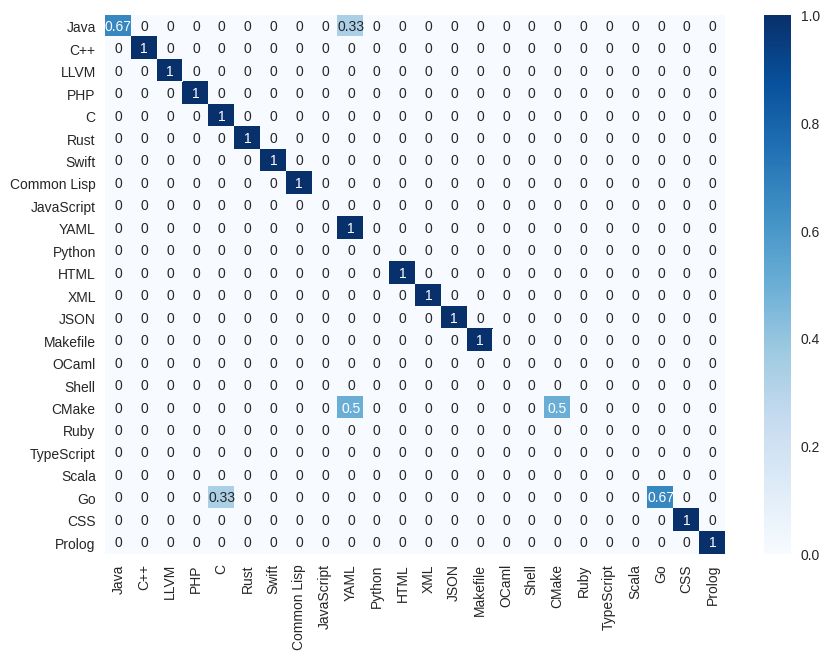

In [26]:
clf = parameters[0]['clf'][0]
name = parameters[0]['name']
parameters[0].pop('clf')
parameters[0].pop('name')

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[0], cv=3, verbose=2)

grid.fit(X_train, lb.transform(y_train))
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, lb.transform(y_test))}')

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

ANN = result[1]

y_pred = ANN["grid"].best_estimator_.predict(X_test)

def map_to_array(x):
    final = [0] * len(accepted)
    final[x] = 1
    return final
    
y_pred = np.array(list(map(map_to_array, list(y_pred))))
conf_matrix = confusion_matrix(y_test, lb.inverse_transform(y_pred), normalize='true', labels=accepted)
df_cm = pd.DataFrame(conf_matrix, index=accepted,
                     columns=accepted)
plt.figure(figsize=(10, 7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt

Questa matrice fa riferimento al miglior modello (Random Forest con parametri precedenti). I valori sono discreti. Il linguaggio che ha il peggior risultato è TypeScript che viene spesso confuso con Java e JavaScript.

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300 


/home/federico/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300, total=   2.7s
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300, total=   0.4s
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300 
[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=300, total=   0.4s
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500 
[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500, total=   0.6s
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500 
[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500, total=   0.6s
[CV] clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500 
[CV]  clf__criterion=gini, clf__max_features=sqrt, clf__min_samples_split=3, clf__n_estimators=500, total=   0.6s
[CV] clf__criterion=gini, clf__max

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:   23.8s finished


 - RandomForestClassifier Accuracy: 0.8333333333333334


<module 'matplotlib.pyplot' from '/home/federico/.local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

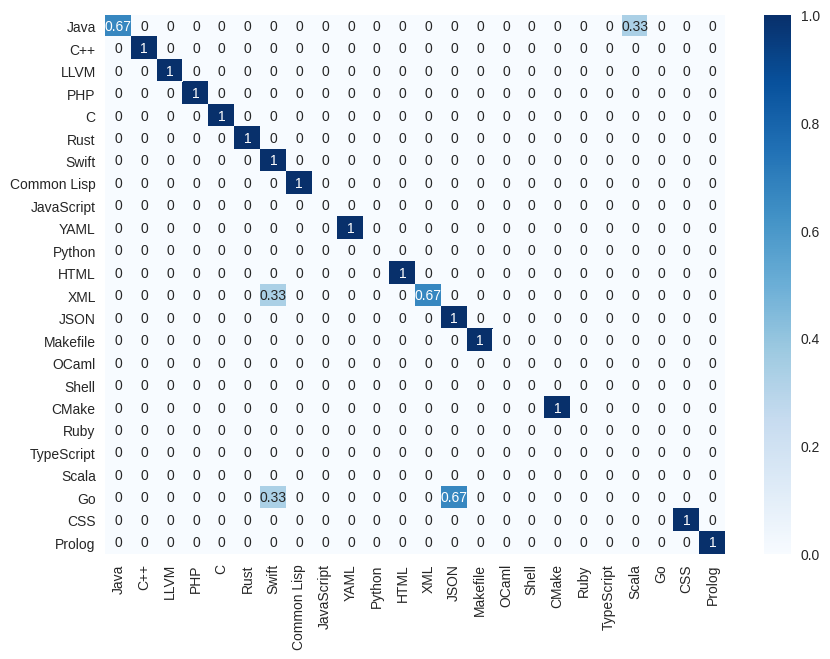

In [27]:
clf = parameters[1]['clf'][0]
name = parameters[1]['name']
parameters[1].pop('clf')
parameters[1].pop('name')

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', tfidf_vectorizer),
    ('clf', clf)]
)
grid = GridSearchCV(pipe_RF, param_grid=parameters[1], cv=3, verbose=2)

grid.fit(X_train, y_train)
# Evaluation
print(f' - {name} Accuracy: {grid.score(X_test, y_test)}')

# storing result
result.append({
    'grid': grid,
    'name': name,
    'classifier': grid.best_estimator_,
    'best score': grid.best_score_,
    'best params': grid.best_params_,
    'cv': grid.cv
    })

RandomForestP = result[2]


y_pred = RandomForestP["grid"].best_estimator_.predict(X_test)

array = confusion_matrix(y_test, y_pred, normalize='true', labels=accepted)
df_cm = pd.DataFrame(array, index =accepted,
              columns =accepted)
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.yticks(rotation=0)
plt

Per Random Forest mostro le 20 stringhe con *feature importances* più alto:

<AxesSubplot:>

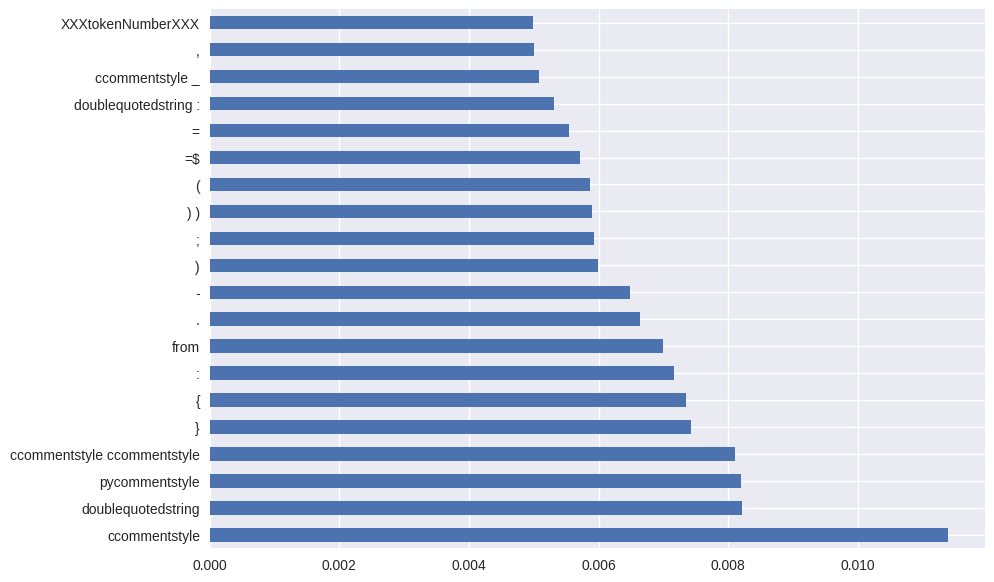

In [28]:
plt.style.use('seaborn')
        
importances = RandomForestP["grid"].best_estimator_["clf"].feature_importances_

plt.figure(figsize = (10,7))

(pd.Series(importances, index=tfidf_vectorizer.get_feature_names())
   .nlargest(20)
   .plot(kind='barh'))  

# Comparison


Comparazione tra i migliori:

In [29]:
with open('RandomForest.pkl', 'wb') as fid:
    cPickle.dump(RandomForestP["grid"].best_estimator_, fid) 

with open('SVC.pkl', 'wb') as fid:
    cPickle.dump(SVC["grid"].best_estimator_, fid) 

result = sorted(result, key=operator.itemgetter('best score'), reverse=True)

pd.DataFrame.from_dict([{
      'name':v['name'],
      'score': v['best score'],
      'param': v['best params']
     } for v in result])

,name,score,param
0,RandomForestClassifier,0.822222,"{'clf__criterion': 'gini', 'clf__max_features'..."
1,SVC,0.766667,"{'clf__C': 100, 'clf__class_weight': 'balanced..."
2,ANN,0.744444,"{'clf__clf__batch_size': 32, 'clf__clf__epochs..."


Quelli che risultano essere i migliori parametri:

In [30]:
result[0]['best params']

{'clf__criterion': 'gini',
 'clf__max_features': 'sqrt',
 'clf__min_samples_split': 3,
 'clf__n_estimators': 500}